## LDA 3

# Fitting an LDA to our corpus

We plan to perform topic modeling using *Latent Dirichlet Allocation* (abbreviated as LDA). An LDA is a *generative model* that learns a group of categories (or *topics*) for words that occur together in a corpus of documents. For a technical presentation of LDAs, see [Appendix A](404).

Let's start loading up our corpus:

In [1]:
import json
import re
import os
import sys 

# Jupyter Notebooks are not good at handling relative imports.
# Best solution (not great practice) is to add the project's path
# to the module loading paths of sys.

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.loaders import loadCorpusList, saveCorpus

corpusPath = '../data/corpus'

corpusList = loadCorpusList(corpusPath)
corpusList = [a for a in corpusList if a.lang == "es"]

For `gensim`, we will need to provide the bag-of-words as a list of strings. Thus, we start by implementing a generic function that takes objects of our article class and returns the list representation of its bag of words. It includes a hot fix to a problem we are facing in the generation of the bag of words: there are several spaces that make `bagOfWords.split(" ")` contain empty strings.

In [2]:
def prepare_bag_of_words(article):
    """
    A hot fix on some empty strings.
    """
    bow = article.bagOfWords
    bow = bow.split(" ")
    return [w for w in bow if len(w) > 1]

In [3]:
from gensim import corpora

In [4]:
dictionary = corpora.Dictionary([
    prepare_bag_of_words(a) for a in corpusList
])
corpus = [dictionary.doc2bow(prepare_bag_of_words(a)) for a in corpusList]

Using this dictionary, we can create an LdaModel:

TODO: change for LdaModelMulticore (?).

In [5]:
from gensim.models.ldamodel import LdaModel

In [6]:
n_topics = 10
lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

## Visualizing an LDA using pyLDAvis

One of the advantages of using `gensim` is `pyLDAvis`, a visualization utility that takes `gensim`'s objects (the `lda` model, the `corpus` and the `dictionary` we created above) and creates a visualization of the `lda`'s latent space and topic representation:

In [28]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

We can save this model:

In [11]:
lda.save(f"LDA_gensim_{n_topics}.model")

In [12]:
ls

1-Preprocessing_Artifacts-and-Stopwords.ipynb
2-Preprocessing-Stopword-removal.ipynb
3-LDA-using-gensim.ipynb
3-LDA_Fitting.ipynb
LDA_gensim_10.model
LDA_gensim_10.model.expElogbeta.npy
LDA_gensim_10.model.id2word
LDA_gensim_10.model.state
LDA_k_20.jl
LDA_k_50.jl
models/
wordlists/


## Analyzing the Model Coherence

In [25]:
from gensim.models import CoherenceModel

In [27]:
texts = [
    prepare_bag_of_words(a) for a in corpusList
]

In [15]:
coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.38878617966222534


This coherence score allows us to do a search for the "best" `n_topics`. Let's print the coherence doing a normal search between 10 and 150 topics. Notice that this coherence score is sensitive to the random number generation that is used when creating the `lda`.

In [16]:
coherence_per_topics = {}
for n_topics in range(10, 200, 10):
    coherences = []
    for _ in range(3):
        lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)
        coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
        c = coherence_model_lda.get_coherence()
        coherences.append(c)
        print(f'Topics: {n_topics}. Coherence Score: {c}')
    coherence_per_topics[n_topics] = coherences

Topics: 10. Coherence Score: 0.3953344477170396
Topics: 20. Coherence Score: 0.41243755522172315
Topics: 30. Coherence Score: 0.3918896770429213
Topics: 40. Coherence Score: 0.4091358025355166
Topics: 50. Coherence Score: 0.4098096823426642
Topics: 60. Coherence Score: 0.4044007244335085
Topics: 70. Coherence Score: 0.41026726256297735
Topics: 80. Coherence Score: 0.4099083999675628
Topics: 90. Coherence Score: 0.4075532626033013
Topics: 100. Coherence Score: 0.4208462589828421
Topics: 110. Coherence Score: 0.42427263834579465
Topics: 120. Coherence Score: 0.41544696399180536
Topics: 130. Coherence Score: 0.4201812530339914
Topics: 140. Coherence Score: 0.4260739796399586
Topics: 150. Coherence Score: 0.42230164665127373
Topics: 160. Coherence Score: 0.41068903309657623
Topics: 170. Coherence Score: 0.42956679285381455
Topics: 180. Coherence Score: 0.4079833938876326
Topics: 190. Coherence Score: 0.411407152608949


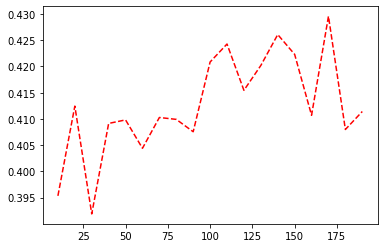

In [17]:
import numpy as np
import matplotlib.pyplot as plt

x = list(coherence_per_topics.keys())
y = [coherence_per_topics[n] for n in x]

plt.plot(x, y, "--r")

As we can see, the coherence moves between 0.39 and 0.43. The optimal amount of topics seems to be upwards of 100 topics. However, we will run this same gridsearch, but storing more metadata about each model (such as: amount of documents per topic, and time it takes to train)

## Running a more complete grid-search

In [23]:
import time

In [31]:
from collections import defaultdict

In [30]:
def articles_per_topic(lda):
    """
    TODO: I'm not exactly sure that corpusList and corpus share order.
    The only thing that this affects is the name of the articles being printed.
    """
    n_articles_per_topic = defaultdict(int)
    for art, doc in zip(corpusList, corpus):
        topics = lda.get_document_topics(doc)
        if len(topics) > 0:
            first_topic = topics[0][0]
            n_articles_per_topic[first_topic] += 1
        else:
            # -1 will represent no-topic.
            # This also needs to be fixed:
            # https://github.com/RaRe-Technologies/gensim/issues/2115#issuecomment-443113360
            n_articles_per_topic[-1] += 1
            print(f"No topic for article {art}")
    
    return n_articles_per_topic

In [47]:
from gensim.models.ldamulticore import LdaMulticore

In [58]:
def get_metadata(n_topics, verbose=True):
    if verbose:
        print(f"Training an LDA model with {n_topics}.")

    start_lda = time.time()
    lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)
    end_lda = time.time()
    
    time_lda = end_lda - start_lda
    
    if verbose:
        print(f"Time elapsed: {time_lda}")
        print(f"Training the coherence model with {n_topics}.")

    start_coherence = time.time()
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    end_coherence = time.time()
    
    time_coherence = end_coherence - start_coherence

    if verbose:
        print(f"Time elapsed: {time_coherence}")

    c = coherence_model_lda.get_coherence()
    log_perplexity = lda.log_perplexity(corpus)
    n_articles_per_topic = articles_per_topic(lda)
    
    if verbose:
        print(f"For {n_topics}:")
        print("\t" + f"Coherence: {c}")
        print("\t" + f"Log Perplexity: {log_perplexity}")

    metadata = {
        "coherence": c,
        "log_perplexity": log_perplexity,
        "time_lda": time_lda,
        "time_coherence": time_coherence,
        "n_articles_per_topic": dict(n_articles_per_topic)
    }

    return metadata

TODO: Run it again after addressing this comment: https://github.com/RaRe-Technologies/gensim/issues/2115#issuecomment-443113360

In [56]:
def gridsearch(min_topics, max_topics, step, iterations=3, verbose=True):
    """
    Computes an array like this:
    experiment = {
        n_topics: {
            0: get_metadata(n_topics),
            1: get_metadata(n_topics),
            ...
            iterations - 1: get_metadata(n_topics)
        }
    }
    and we expect all these inner get_metadata to be slightly different
    due to stochasticity in the models.
    
    TODO: document better.
    """
    experiment = {}
    for n_topics in range(min_topics, max_topics, step):
        experiment[n_topics] = {}
        for i in range(iterations):
            metadata = get_metadata(n_topics, verbose=verbose)
            experiment[n_topics][i] = metadata
    
    return experiment

**Careful:** this gridsearch can take a whole evening.

In [59]:
experiment = gridsearch(10, 200, 10, iterations=3, verbose=False)

No topic for article Jorge Aurelio Díaz (2001/01/01). La ética reconstructiva. 0(116)
No topic for article Jorge Aurelio Díaz (2001/01/01). Hegel y la modernidad según Karl Barth. 0(116)
No topic for article Jesús Soto (1969/01/01). Tú, mujer, avanzas sola entre la noche apenas con un perrito imaginario. 0(32-34)
No topic for article Ramón Garzón (1973/01/01). Nietzsche y Mao. 0(42-45)
No topic for article Alberto Aguirre (1969/01/01). Casa de víboras. 0(32-34)
No topic for article Lisímaco Parra (2001/01/01). Estética, retorica y conocimiento: A.G. Baumgarten. 0(116)
No topic for article Anselmo González Jara (1963/07/01). La Teoría de la Ciencia y las Ideas de Wilhelm Windelband sobre la Historia. 5(18)
No topic for article Germán Rubiano Caballero (1967/01/01). La plástica colombiana en 1966. 0(27-29)
No topic for article Jürgen Habermas (1970/01/01). Un intelectual filósofo. 0(35-37)
No topic for article Arnold J. Toynbee (1951/07/01). La Sociedad Andina. 1(2)
No topic for article 

No topic for article Bernardo Salcedo (1969/01/01). Flash. 0(32-34)
No topic for article Maria Eugenia Valentié (1953/01/01). Lo social y lo absoluto en el pensamiento de Simone Weil. 2(7-8)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/01/01). I. Vida de la filosofía. 4(13)
No topic for article Jaime Jaramillo Uribe (1963/07/01). La muerte de Eduardo Spranger. 5(18)
No topic for article Francisco Posada Díaz (1967/01/01). La tentativa de revolución burguesa en Colombia y sus resultados. 0(27-29)
No topic for article Luz Marina Barreo (2007/05/01). Sobre los cambios de perspectiva en el conocimiento. 56(134)
No topic for article Fernando Urbina (1973/01/01). Un mito cosmogónico de los Murui-Muinane. 0(42-45)
No topic for article Edelweiss Pacciotti de González (1964/05/01). Jorge Seferis: Premio Nobel de la Literatura 1963. 6(21-22)
No topic for article C. Sanz de Santamaría (1952/05/01). La Dialéctica del Liberalismo y El Totalitarismo. 2(5)
No topic for a

No topic for article Guillermo Hoyos Vásquez (2001/01/01). La filosofía política de Jürgen Habermas. 0(116)
No topic for article Francisco Leal Buitrago (1969/01/01). Aspectos de la vida política en Latinoamérica. 0(32-34)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1951/07/01). Notas bibliográficas. 1(2)
No topic for article Maurice Godelier (1967/01/01). Objeto y método de la antropología económica. 0(27-29)
No topic for article Bernhard Waldenfels (2001/01/01). Mundo familiar y mundo extraño: problemas de la intersubjetividad y de la interculturalidad a partir de Edmund Husserl. 0(116)
No topic for article Augusto Díaz (1969/01/01). Georg Lukacs: volver a lo concreto. 0(32-34)
No topic for article Abraham Fernández de Soto (1952/01/01). Exposición y Crítica del Materialismo Histórico. 1(3-4)
No topic for article Germán Carrera Damas (1969/01/01). La historiografía venezolana actual. 0(32-34)
No topic for article Danilo Cruz Vélez (1951/01/01). La idea de un

No topic for article Rubén Sierra Mejía (1967/01/01). Estado actual de la filosofía en Colombia. 0(27-29)
No topic for article Antonio Montaña (1968/01/01). Esta maldita niebla. 0(30-31)
No topic for article Germán Meléndez (2001/01/01). La justificación estética del mal en el joven Nietzsche. 0(116)
No topic for article Roberto Burgos (1969/01/01). Cuando el salitre destroza las palabras. 0(32-34)
No topic for article José Gaos (1951/01/01). El Nuevo Mundo. 1(1)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1964/05/01). Actividades de la Facultad. 6(21-22)
No topic for article Howard Rochester (1967/01/01). Otelo: tragedia de ambiente militar y domestico. 0(27-29)
No topic for article Fernando Moledo (2007/01/01). Immanuel Kant: La declaración pública de Kant contra Fichte. 56(133)
No topic for article Jesús Mosterín (1993/01/01). Los números naturales como base de datos universal. 0(92-93)
No topic for article José Enrique Corrales E. (1963/01/01). Egloga IV. 

No topic for article Víctor Florian (1969/01/01). Joseph Gabel: la falsa conciencia. 0(32-34)
No topic for article Rafael Gutiérrez Girardot (1953/01/01). El análisis intencional y el problema del pensamiento especulativo. 2(7-8)
No topic for article Rafael Maya (1969/01/01). Escritos literarios. 0(32-34)
No topic for article Andrés Crelier (2007/05/01). Los aspectos éticos de la comunidad en Charles S. Peirce. 56(134)
No topic for article Jose Luis Cárdenas (2003/09/01). José Granés: LA GRAMÁTICA DE UNA CONTROVERSIA CIENTÍFICA. 52(123)
No topic for article Guillermo Hoyos Vásquez (1978/01/01). El problema de la libertad humana en Kant. 0(51-52)
No topic for article Jaime Jaramillo Uribe (1962/01/01). Bentham y los utilitaristas colombianos del siglo XIX. 4(13)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/07/01). I. Vida de la filosofía. 5(18)
No topic for article Valores Ideas y (1965/01/01). Información Filosófica. 7(25-26)
No topic for article Giacomo D

No topic for article Freddy Téllez (1978/01/01). Lukacs y el prefacio autocrítico de 1967. 0(51-52)
No topic for article J. A. Doerig (1953/01/01). Contribución de Suiza a la Lingüística. 2(7-8)
No topic for article Enrique Gómez Arboleya (1952/01/01). Recepción de Ideas y Valores en Colombia y en el exterior. 1(3-4)
No topic for article Cayetano Betancur (1951/01/01). Designios. 1(1)
No topic for article Abraham Fernández de Soto (1952/09/01). Visión social y económica de América. 2(6)
No topic for article Freddy Téllez (1984/01/01). La materialidad del totalitarismo. 0(64-65)
No topic for article Carlos Bernardo Gutiérrez (1964/05/01). El solipsismo en Witfgenstein apreciación critica desde un punto de vista fenomenológico. 6(21-22)
No topic for article David Sobrevilla (1978/01/01). La filosofía alemana actual. 0(51-52)
No topic for article Renato Perino (1962/09/01). Bases, problemática y estado actual de la Teología. 4(15-16)
No topic for article Ramón Pérez-Mantilla (1967/01/01).

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y epistemología. 0(42-45)
No topic for article Víctor Florian (1969/01/01). J

No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01). Vida de la filosofía. 2(6)
No topic for article Louis Althusser (1968/01/01). Sobre el conocimiento del arte: respuesta a Andre Daspre. 0(30-31)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/01/01). Vida de la Facultad. 5(17)
No topic for article Freddy Téllez (1978/01/01). 

No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/07/01). Hacia una Ontología dialéctica de la Existencia. 1(2)
No topic for article Magdalena Holguín (1984/01/01). El enigma d

No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y e

No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideolo

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y epistemología. 0(42-45)
No topic for article Víctor Florian (1969/01/01). J

No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01). Vida de la filosofía. 2(6)
No topic for article Louis Althusser (1968/01/01). Sobre el conocimiento del arte: respuesta a Andre Daspre. 0(30-31)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/01/01). Vida de la Facultad. 5(17)
No topic for article Freddy Téllez (1978/01/01). Lukacs y el prefacio autocrítico de 1967. 0(51-52)
No topic for article J. A. Doerig (1953/01/01). Contribución de Suiza a la Lingüística. 2(7-8)
No topic for article Enrique Gómez Arboleya (1952/0

No topic for article Freddy Tellez (1980/01/01). El monolito Sartre. 0(59-60)
No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/

No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y e

No topic for article Ideas y Valores Revista Colombiana de Filosofía (1969/01/01). La solución para los tugurios: ¿la "Píldora"?. 0(32-34)
No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (196

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article ]uozas Zaranka (1978/01/01). Platón y Huxley: dos utopías. 0(51-52)
No topic for article Platón Platón (1953/01/01). Carta VII de Platón sobre su experiencia politica en Siracusa: Platón, a los parientes y amigos de Dion, ¡Salud!. 2(7-8)
No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del 

No topic for article Ideas y Valores Revista Colombiana de Filosofía (1969/01/01). La solución para los tugurios: ¿la "Píldora"?. 0(32-34)
No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (196

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y e

No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01). Vida de la filosofía. 2(6)
No topic for article Louis Althusser (1968/01/01). Sobre el conocimiento del arte: respuesta a Andre Daspre. 0(30-31)
No topic for article Ideas y 

No topic for article Guillemina Garmendia de Camusso (1980/01/01). El programa moral de Sartre. 0(59-60)
No topic for article Helena Araujo (1968/01/01). Acerca de la narrativa de Caballero Calderón. 0(30-31)
No topic for article Freddy Tellez (1980/01/01). El monolito Sartre. 0(59-60)
No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de l

No topic for article Marie-Jean Vinciguerra (1968/01/01). La "Atala" de Chateaubriand y la "María" de Isaacs. 0(30-31)
No topic for article ]uozas Zaranka (1978/01/01). Platón y Huxley: dos utopías. 0(51-52)
No topic for article Platón Platón (1953/01/01). Carta VII de Platón sobre su experiencia politica en Siracusa: Platón, a los parientes y amigos de Dion, ¡Salud!. 2(7-8)
No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenol

No topic for article Humberto Echeverry Cardona (1963/01/01). Reseña de libros. 5(17)
No topic for article Danilo Cruz Vélez (1962/09/01). Husserl y la filosofía griega. 4(15-16)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1969/01/01). La solución para los tugurios: ¿la "Píldora"?. 0(32-34)
No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et

No topic for article Lisímaco Parra París (1984/01/01). La Estética de La antigüedad.. 0(64-65)
No topic for article Alberto Aguirre González (1967/01/01). El comienzo de las ideas. 0(27-29)
No topic for article Bertrand Russell (1970/01/01). Para lo que he vivido. 0(35-37)
No topic for article Daniel Herrera Restrepo (1962/01/01). Teleología de la razón y filosofía: estudio de un inédito hursseliano de 1911. 4(13)
No topic for article Mary Mora Rubio (1968/01/01). Significación de Julio Flórez. 0(30-31)
No topic for article Luis Villavicencio (2007/09/01). La concepción política de la persona y las visiones constitutivas del bien. 56(135)
No topic for article Luis Eduardo Hoyos (2001/01/01). Cosa en sí después de Kant: la solución de Salomon Maimon. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Carlos Castilla del Pino: La alienación en la mujer. 0(32-34)
No topic for article Gonther Schütz (1964/05/01). Una filosofía de la gloria: Con ocasión del septuagésimo aniversario

No topic for article Alfonso Rincón González (1973/01/01). Ciencia e ideología. 0(42-45)
No topic for article Cayetano Betancur (1952/01/01). La Tierra en el Centro del Universo. 1(3-4)
No topic for article Antonio Bergmann (1967/01/01). EI ser erguido y la existencia. 0(27-29)
No topic for article Elviera Bobach (1980/01/01). La Herencia Sartriana. 0(59-60)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/01/01). Vida de la filosofía. 5(17)
No topic for article Marie-Jean Vinciguerra (1968/01/01). La "Atala" de Chateaubriand y la "María" de Isaacs. 0(30-31)
No topic for article ]uozas Zaranka (1978/01/01). Platón y Huxley: dos utopías. 0(51-52)
No topic for article Platón Platón (1953/01/01). Carta VII de Platón sobre su experiencia politica en Siracusa: Platón, a los parientes y amigos de Dion, ¡Salud!. 2(7-8)
No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Ob

No topic for article Ideas y Valores Revista Colombiana de Filosofía (1969/01/01). La solución para los tugurios: ¿la "Píldora"?. 0(32-34)
No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (196

No topic for article Daniel Herrera Restrepo (1962/01/01). Teleología de la razón y filosofía: estudio de un inédito hursseliano de 1911. 4(13)
No topic for article Mary Mora Rubio (1968/01/01). Significación de Julio Flórez. 0(30-31)
No topic for article Luis Villavicencio (2007/09/01). La concepción política de la persona y las visiones constitutivas del bien. 56(135)
No topic for article Luis Eduardo Hoyos (2001/01/01). Cosa en sí después de Kant: la solución de Salomon Maimon. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Carlos Castilla del Pino: La alienación en la mujer. 0(32-34)
No topic for article Gonther Schütz (1964/05/01). Una filosofía de la gloria: Con ocasión del septuagésimo aniversario de la muerte de Jules Barbey d'Aurevilly. 6(21-22)
No topic for article Luis Enrique Orozco (1973/01/01). Marx y el materialismo filosófico. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01). Publicaciones recibidas. 2(6)
No topic for article Gonzalo Serrano (200

No topic for article Alfonso Rincón González (1973/01/01). Ciencia e ideología. 0(42-45)
No topic for article Cayetano Betancur (1952/01/01). La Tierra en el Centro del Universo. 1(3-4)
No topic for article Antonio Bergmann (1967/01/01). EI ser erguido y la existencia. 0(27-29)
No topic for article Elviera Bobach (1980/01/01). La Herencia Sartriana. 0(59-60)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/01/01). Vida de la filosofía. 5(17)
No topic for article Marie-Jean Vinciguerra (1968/01/01). La "Atala" de Chateaubriand y la "María" de Isaacs. 0(30-31)
No topic for article ]uozas Zaranka (1978/01/01). Platón y Huxley: dos utopías. 0(51-52)
No topic for article Platón Platón (1953/01/01). Carta VII de Platón sobre su experiencia politica en Siracusa: Platón, a los parientes y amigos de Dion, ¡Salud!. 2(7-8)
No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Ob

No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01).

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y epistemología. 0(42-45)
No topic for article Víctor Florian (1969/01/01). J

No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01).

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y epistemología. 0(42-45)
No topic for article Víctor Florian (1969/01/01). J

No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01). Vida de la filosofía. 2(6)
No topic for article Louis Althusser (1968/01/01). Sobre el conocimiento del arte: respuesta a Andre Daspre. 0(30-31)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/01/01). Vida de la Facultad. 5(17)
No topic for article Freddy Téllez (1978/01/01). Lukacs y el prefacio autocrítico de 1967. 0(51-52)
No topic for article J. A. Doerig (1953/01/01). Contribución de Suiza a la Lingüística. 2(7-8)
No topic for article Enrique Gómez Arboleya (1952/0

No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/07/01). Hacia una Ontología dialéctica de la Existencia. 1(2)
No topic for article Magdalena Holguín (1984/01/01). El enigma d

No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y epistemología. 0(42-45)
No topic for article Víctor Florian (1969/01/01). J

No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01). Vida de la filosofía. 2(6)
No topic for article Louis Althusser (1968/01/01). Sobre el conocimiento del arte: respuesta a Andre Daspre. 0(30-31)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/01/01). Vida de la Facultad. 5(17)
No topic for article Freddy Téllez (1978/01/01). Lukacs y el prefacio autocrítico de 1967. 0(51-52)
No topic for article J. A. Doerig (1953/01/01). Contribución de Suiza a la Lingüística. 2(7-8)
No topic for article Enrique Gómez Arboleya (1952/0

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y epistemología. 0(42-45)
No topic for article Víctor Florian (1969/01/01). J

No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01).

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y epistemología. 0(42-45)
No topic for article Víctor Florian (1969/01/01). J

No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01). Vida de la filosofía. 2(6)
No topic for article Louis Althusser (1968/01/01). Sobre el conocimiento del arte: respuesta a Andre Daspre. 0(30-31)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/01/01). Vida de la Facultad. 5(17)
No topic for article Freddy Téllez (1978/01/01). Lukacs y el prefacio autocrítico de 1967. 0(51-52)
No topic for article J. A. Doerig (1953/01/01). Contribución de Suiza a la Lingüística. 2(7-8)
No topic for article Enrique Gómez Arboleya (1952/0

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y e

No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01).

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y epistemología. 0(42-45)
No topic for article Víctor Florian (1969/01/01). J

No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01). Vida de la filosofía. 2(6)
No topic for article Louis Althusser (1968/01/01). Sobre el conocimiento del arte: respuesta a Andre Daspre. 0(30-31)
No topic for article Ideas y 

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y e

No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01). Vida de la filosofía. 2(6)
No topic for article Louis Althusser (1968/01/01). Sobre el conocimiento del arte: respuesta a Andre Daspre. 0(30-31)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/01/01). Vida de la Facultad. 5(17)
No topic for article Freddy Téllez (1978/01/01). 

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y e

No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01).

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y e

No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideología o Marx contra Marx. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01).

No topic for article Mary Mora Rubio (1968/01/01). Significación de Julio Flórez. 0(30-31)
No topic for article Luis Villavicencio (2007/09/01). La concepción política de la persona y las visiones constitutivas del bien. 56(135)
No topic for article Luis Eduardo Hoyos (2001/01/01). Cosa en sí después de Kant: la solución de Salomon Maimon. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Carlos Castilla del Pino: La alienación en la mujer. 0(32-34)
No topic for article Gonther Schütz (1964/05/01). Una filosofía de la gloria: Con ocasión del septuagésimo aniversario de la muerte de Jules Barbey d'Aurevilly. 6(21-22)
No topic for article Luis Enrique Orozco (1973/01/01). Marx y el materialismo filosófico. 0(42-45)
No topic for article . Ideas y Valores (1952/09/01). Publicaciones recibidas. 2(6)
No topic for article Gonzalo Serrano (2001/01/01). Artes de la razón: una historia de la demostración en la Edad Media. 0(116)
No topic for article Francisco Posada (1968/01/01). Brecht

No topic for article Abraham Fernández de Soto (1953/01/01). Régimen bicameral y senado corporativo. 2(7-8)
No topic for article Alfonso Rincón González (1973/01/01). Ciencia e ideología. 0(42-45)
No topic for article Cayetano Betancur (1952/01/01). La Tierra en el Centro del Universo. 1(3-4)
No topic for article Antonio Bergmann (1967/01/01). EI ser erguido y la existencia. 0(27-29)
No topic for article Elviera Bobach (1980/01/01). La Herencia Sartriana. 0(59-60)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/01/01). Vida de la filosofía. 5(17)
No topic for article Marie-Jean Vinciguerra (1968/01/01). La "Atala" de Chateaubriand y la "María" de Isaacs. 0(30-31)
No topic for article ]uozas Zaranka (1978/01/01). Platón y Huxley: dos utopías. 0(51-52)
No topic for article Platón Platón (1953/01/01). Carta VII de Platón sobre su experiencia politica en Siracusa: Platón, a los parientes y amigos de Dion, ¡Salud!. 2(7-8)
No topic for article J. O. Melo (1962/09/0

No topic for article Ideas y Valores Revista Colombiana de Filosofía (1969/01/01). La solución para los tugurios: ¿la "Píldora"?. 0(32-34)
No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (196

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y e

No topic for article Ideas y Valores Revista Colombiana de Filosofía (1969/01/01). La solución para los tugurios: ¿la "Píldora"?. 0(32-34)
No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (196

No topic for article Guillemina Garmendia de Camusso (1980/01/01). El programa moral de Sartre. 0(59-60)
No topic for article Helena Araujo (1968/01/01). Acerca de la narrativa de Caballero Calderón. 0(30-31)
No topic for article Freddy Tellez (1980/01/01). El monolito Sartre. 0(59-60)
No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de l

No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y e

No topic for article Ideas y Valores Revista Colombiana de Filosofía (1969/01/01). La solución para los tugurios: ¿la "Píldora"?. 0(32-34)
No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (196

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/01/01). Vida de la filosofía. 5(17)
No topic for article Marie-Jean Vinciguerra (1968/01/01). La "Atala" de Chateaubriand y la "María" de Isaacs. 0(30-31)
No topic for article ]uozas Zaranka (1978/01/01). Platón y Huxley: dos utopías. 0(51-52)
No topic for article Platón Platón (1953/01/01). Carta VII de Platón sobre su experiencia politica en Siracusa: Platón, a los parientes y amigos de Dion, ¡Salud!. 2(7-8)
No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerar

No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/07/01). II. Vida de la Facultad. 5(18)
No topic for article Gonzalo Hernández de Alba (1978/01/01). La historia en la filosofía de Kant. 0(51-52)
No topic for article Herbert Marcuse (1970/01/01). Los manuscritos económico-filosóficos de Marx. 0(35-37)
No topic for article Humberto Echeverry Cardona (1963/01/01). Reseña de libros. 5(17)
No topic for article Danilo Cruz Vélez (1962/09/01). Husserl y la filosofía griega. 4(15-16)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1969/01/01). La solución para los tugurios: ¿la "Píldora"?. 0(32-34)
No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades e

No topic for article Lisímaco Parra París (1984/01/01). La Estética de La antigüedad.. 0(64-65)
No topic for article Alberto Aguirre González (1967/01/01). El comienzo de las ideas. 0(27-29)
No topic for article Bertrand Russell (1970/01/01). Para lo que he vivido. 0(35-37)
No topic for article Daniel Herrera Restrepo (1962/01/01). Teleología de la razón y filosofía: estudio de un inédito hursseliano de 1911. 4(13)
No topic for article Mary Mora Rubio (1968/01/01). Significación de Julio Flórez. 0(30-31)
No topic for article Luis Villavicencio (2007/09/01). La concepción política de la persona y las visiones constitutivas del bien. 56(135)
No topic for article Luis Eduardo Hoyos (2001/01/01). Cosa en sí después de Kant: la solución de Salomon Maimon. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Carlos Castilla del Pino: La alienación en la mujer. 0(32-34)
No topic for article Gonther Schütz (1964/05/01). Una filosofía de la gloria: Con ocasión del septuagésimo aniversario

No topic for article Abraham Fernández de Soto (1953/01/01). Régimen bicameral y senado corporativo. 2(7-8)
No topic for article Alfonso Rincón González (1973/01/01). Ciencia e ideología. 0(42-45)
No topic for article Cayetano Betancur (1952/01/01). La Tierra en el Centro del Universo. 1(3-4)
No topic for article Antonio Bergmann (1967/01/01). EI ser erguido y la existencia. 0(27-29)
No topic for article Elviera Bobach (1980/01/01). La Herencia Sartriana. 0(59-60)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1963/01/01). Vida de la filosofía. 5(17)
No topic for article Marie-Jean Vinciguerra (1968/01/01). La "Atala" de Chateaubriand y la "María" de Isaacs. 0(30-31)
No topic for article ]uozas Zaranka (1978/01/01). Platón y Huxley: dos utopías. 0(51-52)
No topic for article Platón Platón (1953/01/01). Carta VII de Platón sobre su experiencia politica en Siracusa: Platón, a los parientes y amigos de Dion, ¡Salud!. 2(7-8)
No topic for article J. O. Melo (1962/09/0

No topic for article Danilo Cruz Vélez (1962/09/01). Husserl y la filosofía griega. 4(15-16)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1969/01/01). La solución para los tugurios: ¿la "Píldora"?. 0(32-34)
No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ball

No topic for article Freddy Tellez (1980/01/01). El monolito Sartre. 0(59-60)
No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/

No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y e

No topic for article Ideas y Valores Revista Colombiana de Filosofía (1969/01/01). La solución para los tugurios: ¿la "Píldora"?. 0(32-34)
No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (196

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y e

No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideolo

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

No topic for article Platón Platón (1953/01/01). Carta VII de Platón sobre su experiencia politica en Siracusa: Platón, a los parientes y amigos de Dion, ¡Salud!. 2(7-8)
No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófi

No topic for article Ideas y Valores Revista Colombiana de Filosofía (1969/01/01). La solución para los tugurios: ¿la "Píldora"?. 0(32-34)
No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (196

No topic for article Helena Araujo (1968/01/01). Acerca de la narrativa de Caballero Calderón. 0(30-31)
No topic for article Freddy Tellez (1980/01/01). El monolito Sartre. 0(59-60)
No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (195

No topic for article J. O. Melo (1962/09/01). Reseñas de libros. 4(15-16)
No topic for article Francisco Soler Grimma (1952/05/01). El Origen de la Obra de Arte y la Verdad en Heidegger. 2(5)
No topic for article Julio Díaz Báez (1970/01/01). Conversación con Heidegger. 0(35-37)
No topic for article Helena Araujo (1967/01/01). El teatro colombiano en 1966. 0(27-29)
No topic for article José Luis Romero (1963/07/01). Vicente Fatone. 5(18)
No topic for article Eugenio Barney Cabrera (1967/01/01). El itinerario de Alejandro Obregón. 0(27-29)
No topic for article Jorge Aurelio Díaz A. (1973/01/01). ¿Qué es la fenomenología del espíritu?. 0(42-45)
No topic for article Marion Heinz (2001/01/01). La posición de Herder en el conflicto del panteísmo. 0(116)
No topic for article Valores Ideas y (1980/01/01). Información Filosófica. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Tesis sobre Hegel y la revolución. 0(30-31)
No topic for article Víctor Florián (1973/01/01). Materialismo y e

No topic for article Hernando Delgado Campo (1952/09/01). Notas bibliográficas. 2(6)
No topic for article Luis Enrique García Restrepo (1980/01/01). Reseñas. 0(59-60)
No topic for article Karl Korsch (1968/01/01). Diez tesis sobre el marxismo de hoy. 0(30-31)
No topic for article Hermes Tovar Pinzón (1970/01/01). Sobre la enseñanza de las Humanidades en la Universidad Nacional. 0(35-37)
No topic for article Ideas y Valores Revista Colombiana de Filosofía (1962/05/01). I. Vida de la filosofía. 4(14)
No topic for article Juozas Zaranka (1964/09/01). Elogio de la paz I. 10. 6(23-24)
No topic for article Freddy Téllez (1968/01/01). Louis Althusser: "Montesquieu: La politique et l'histoire". 0(30-31)
No topic for article Myriam de Aragón (1969/01/01). Manuel Ballestero: Marx o la crítica como fundamento. 0(32-34)
No topic for article Carolina Ospina (1962/01/01). El espíritu crítico de Montaigne. 4(13)
No topic for article Freddy Téllez (1973/01/01). Emilio de Ipola y la teoría de la ideolo

No topic for article Rubén Sierra Mejía (1973/01/01). La tarea crítica en la epistemología y sus apoyos semánticos. 0(42-45)
No topic for article Alejandro Rosas (2001/01/01). Kant, espíritus y noúmenos. 0(116)
No topic for article Myriam de Aragón (1969/01/01). Los derechos humanos. 0(32-34)
No topic for article Jorge Eliecer Ruíz (1968/01/01). Pedro Gómez Valderrama: "El retablo de maese Pedro". 0(30-31)
No topic for article Tupac Cruz (2007/09/01). Urphänomen y su transposición: Benjamin y el idealismo goetheano. 56(135)
No topic for article Carlos G. Patarroyo (trad.) (2007/09/01). De la inexistencia de la materia. Segunda parte, Capítulo II, Sección 2 del Ensayo sobre la naturaleza e imputación de la verdad, en oposición a la sofistería y al escepticismo. 56(135)
No topic for article Emmanuel Kant (1952/01/01). De los habitantes de los astros. 1(3-4)
No topic for article Eduardo Camacho Guizado (1967/01/01). En el colegio. 0(27-29)
No topic for article Luis E. Nieto Arteta (1951/0

Finally, we can save it for further analysis later on:

In [7]:
import json

In [63]:
with open("../data/gridsearch.json", "w") as fp:
    json.dump(experiment, fp)

## Understanding the gridsearch results 

In [8]:
with open("../data/gridsearch.json") as fp:
    gridsearch = json.load(fp)

In [10]:
gridsearch

{'10': {'0': {'coherence': 0.38753652920908277,
   'log_perplexity': -8.641088730568697,
   'time_lda': 103.96097111701965,
   'time_coherence': 0.007668972015380859,
   'n_articles_per_topic': {'0': 462,
    '3': 295,
    '4': 160,
    '5': 111,
    '1': 158,
    '2': 92,
    '6': 22,
    '7': 15,
    '9': 10,
    '8': 5}},
  '1': {'coherence': 0.4165266204822136,
   'log_perplexity': -8.637117606722926,
   'time_lda': 104.46305584907532,
   'time_coherence': 0.007073163986206055,
   'n_articles_per_topic': {'0': 700,
    '1': 192,
    '3': 128,
    '2': 92,
    '6': 35,
    '7': 87,
    '4': 25,
    '5': 30,
    '8': 36,
    '9': 5}},
  '2': {'coherence': 0.42066469678924445,
   'log_perplexity': -8.62849214320709,
   'time_lda': 103.78927302360535,
   'time_coherence': 0.008419990539550781,
   'n_articles_per_topic': {'4': 79,
    '1': 212,
    '2': 357,
    '0': 330,
    '3': 101,
    '6': 81,
    '8': 16,
    '7': 124,
    '5': 29,
    '9': 1}}},
 '20': {'0': {'coherence': 0.41200

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
def plotting(gridsearch):
    n_topics = np.array(list(gridsearch.keys())).astype(int)
    print(n_topics)
    coherences = []
    log_perplexities = []
    times_lda = []
    times_coherence = []
    
    for n in n_topics:
        iterations = gridsearch[str(n)]
        coherences.append(
            [v["coherence"] for v in iterations.values()]
        )
        log_perplexities.append(
            [v["log_perplexity"] for v in iterations.values()]
        )
        times_lda.append(
            [v["time_lda"] for v in iterations.values()]
        )
        times_coherence.append(
            [v["time_coherence"] for v in iterations.values()]
        )
        
    print(np.mean(coherences, axis=1))
    
    _, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0, 0].plot(n_topics, np.mean(coherences, axis=1))
    axes[0, 0].set_title("Coherence metric")
    
    axes[0, 1].plot(n_topics, np.mean(log_perplexities, axis=1))
    axes[0, 1].set_title("Log perplexity")

    axes[1, 0].plot(n_topics, np.mean(times_lda, axis=1))
    axes[1, 0].set_title("LDA training time")
    
    axes[1, 1].plot(n_topics, np.mean(times_coherence, axis=1))
    axes[1, 1].set_title("Coherence training time")

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190]
[0.40824262 0.41224028 0.3881703  0.38540008 0.42018709 0.4062017
 0.41411985 0.41673694 0.41231119 0.4128591  0.42140746 0.41565879
 0.41594052 0.42498868 0.41538806 0.42066115 0.4109523  0.41603483
 0.41920942]


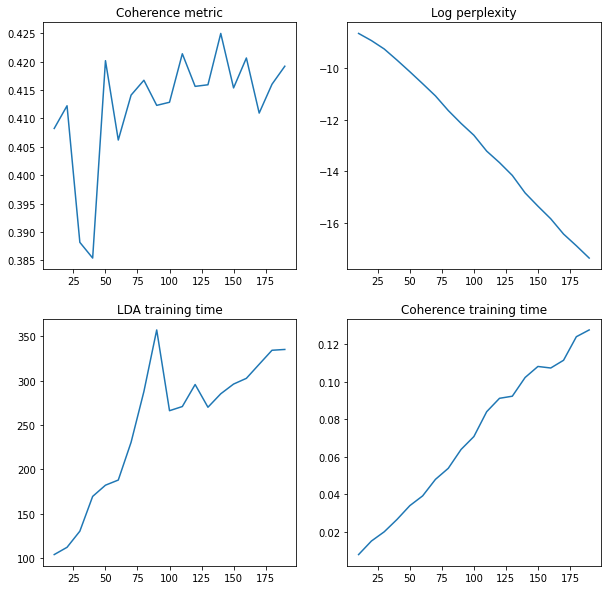

In [37]:
plotting(gridsearch)

# Optimal topics seems to be 90

Let's reload the gridsearch and study what happens around 90 topics

In [6]:
with open("../data/gridsearch.json") as fp:
    g = json.load(fp)

In [9]:
g["90"]

{'0': {'coherence': 0.43097421976149075,
  'log_perplexity': -12.148938459862825,
  'time_lda': 359.4179549217224,
  'time_coherence': 0.06203103065490723,
  'n_articles_per_topic': {'22': 59,
   '2': 244,
   '49': 3,
   '0': 265,
   '9': 56,
   '19': 17,
   '10': 35,
   '11': 129,
   '7': 93,
   '8': 46,
   '6': 49,
   '3': 30,
   '33': 22,
   '59': 5,
   '14': 12,
   '87': 1,
   '60': 5,
   '40': 1,
   '21': 28,
   '54': 2,
   '48': 4,
   '16': 15,
   '1': 22,
   '44': 1,
   '27': 18,
   '29': 4,
   '45': 10,
   '12': 7,
   '13': 35,
   '80': 1,
   '81': 1,
   '35': 16,
   '24': 7,
   '17': 6,
   '26': 2,
   '56': 3,
   '15': 6,
   '5': 20,
   '18': 5,
   '43': 10,
   '51': 2,
   '37': 2,
   '47': 1,
   '28': 4,
   '38': 2,
   '52': 2,
   '46': 2,
   '68': 1,
   '42': 1,
   '32': 3,
   '75': 1,
   '23': 3,
   '71': 3,
   '86': 1,
   '25': 2,
   '41': 2,
   '31': 1,
   '58': 1,
   '36': 1}},
 '1': {'coherence': 0.40422706359377575,
  'log_perplexity': -12.11419124716738,
  'time_lda':

In [13]:
for k in g:
    for v in g[k].values():
        if "-1" in v["n_articles_per_topic"]:
            print(f"Number of topics: {k}")
            print("Number of articles without 1st topic:")
            print(v["n_articles_per_topic"]["-1"])

Number of topics: 100
Number of articles without 1st topic:
254
Number of topics: 100
Number of articles without 1st topic:
254
Number of topics: 100
Number of articles without 1st topic:
254
Number of topics: 110
Number of articles without 1st topic:
254
Number of topics: 110
Number of articles without 1st topic:
254
Number of topics: 110
Number of articles without 1st topic:
254
Number of topics: 120
Number of articles without 1st topic:
254
Number of topics: 120
Number of articles without 1st topic:
254
Number of topics: 120
Number of articles without 1st topic:
254
Number of topics: 130
Number of articles without 1st topic:
254
Number of topics: 130
Number of articles without 1st topic:
254
Number of topics: 130
Number of articles without 1st topic:
254
Number of topics: 140
Number of articles without 1st topic:
254
Number of topics: 140
Number of articles without 1st topic:
254
Number of topics: 140
Number of articles without 1st topic:
254
Number of topics: 150
Number of articles

From 100 onwards, 254 articles get systematically thrown to 0 topics. Weird!

90 doesn't have the no-topics-for-article problem, should we stick with it?

## Sticking with 90

After reading online, people recommend that we save our dictionary in order to prevent randomness in it in the future. I will also set up the seed for the LDA.

In [16]:
dictionary.save("../data/dictionary.gensim")
dictionary = corpora.Dictionary.load("../data/dictionary.gensim")

It has been 47,984 days since Wittgetstein was born (as of today, 09/09/20).

In [17]:
n_topics = 90
lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15, random_state=47984)

In [18]:
lda.save(f"LDA_gensim_{n_topics}_final.model")

In [19]:
ls

1-Preprocessing_Artifacts-and-Stopwords.ipynb
2-Preprocessing-Stopword-removal.ipynb
3-LDA-using-gensim.ipynb
3-LDA_Fitting.ipynb
LDA_gensim_10.model
LDA_gensim_10.model.expElogbeta.npy
LDA_gensim_10.model.id2word
LDA_gensim_10.model.state
LDA_gensim_90_final.model
LDA_gensim_90_final.model.expElogbeta.npy
LDA_gensim_90_final.model.id2word
LDA_gensim_90_final.model.state
LDA_k_20.jl
LDA_k_50.jl
models/
wordlists/


In [21]:
import time

In [32]:
verbose = True
start_coherence = time.time()
coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
end_coherence = time.time()

time_coherence = end_coherence - start_coherence

if verbose:
    print(f"Time elapsed: {time_coherence}")

c = coherence_model_lda.get_coherence()
log_perplexity = lda.log_perplexity(corpus)
n_articles_per_topic = articles_per_topic(lda)

if verbose:
    print(f"For {n_topics}:")
    print("\t" + f"Coherence: {c}")
    print("\t" + f"Log Perplexity: {log_perplexity}")

metadata = {
    "coherence": c,
    "log_perplexity": log_perplexity,
    "time_coherence": time_coherence,
    "n_articles_per_topic": dict(n_articles_per_topic)
}

Time elapsed: 0.07026100158691406
For 90:
	Coherence: 0.4196479730700641
	Log Perplexity: -12.279776295764368
